# Case Study: Wildfire in Sardinia, 2025

**Author(s):** Gisela Romero Candanedo, Julia Wagemann  
**Affiliation:** thriveGEO  
**Contact:** gisela@thrivegeo.com

---

## Introduction

On **June 10th, 2025**, a significant wildfire in Italy's Nuoro Province in Sardinia burned approximately 1000 hectares, a scale that is clearly visible in satellite imagery with a 20-meter resolution. [The European Forest Fire Information System (EFFIS)](https://forest-fire.emergency.copernicus.eu/apps/effis_current_situation/) keeps record of these events.

This notebook demonstrates how two different `.zarr` encoded **Sentinel Mission products** can be combined to provide a compelling and informative overview of an active fire event.<br>

First, we will use reflectance data from **Sentinel-2 L2A** to locate the area of the fire on the ground. At the same time, we will use data from **Sentinel-3 SLSTR Land Surface Temperature** (LST) to demonstrate the intense heat emanating from the fire.

By combining these two datasets, we will not only be able to see the fire location and its state on the day of the event, but also understand its thermal intensity, providing a more complete perspective on its dynamics.

<div style="border: 2.5px solid #999; padding: 1em; border-radius: 6px; background-color: #eaeaea;">
  <strong>Objectives:</strong>
  <ul>
    <li> 🛰️ Visualise potential fires based on the relationship between Sentinel-2 and Sentinel-3 available items through the [EOPF STAC Catalog](https://stac.browser.user.eopf.eodc.eu/?.language=en)</li>
    <li> ✂️ Extract and clip data from Sentinel-3 SLSTR L2</li>
    <li> 🔭 Demostrate the smooth multi-mission integration capabilities `.zarr` format offers to the community</li>
  </ul>
</div>


> **Disclaimer**  
> This notebook demonstrates the use of open source software and is intended for educational and illustrative purposes only. All software used is subject to its respective licenses. The authors and contributors of this notebook make no guarantees about the accuracy, reliability, or suitability of the content or included code. Use at your own discretion and risk. No warranties are provided, either express or implied.

---

## Table of Contents

<ul style="list-style-type:none; padding-left: 0;">
  <li>🔹 <a href="#Setup"><strong>Setup</strong></a></li>
  <li>🔹 <a href="#Section-1"><strong>Setting up the environment</strong></a></li>
  <li>🔹 <a href="#Section-2"><strong>Retrieve Land Surface Temperature (LST) from Sentinel-3 SLSTR L2</strong></a></li>
  <li>🔹 <a href="#Section-2"><strong>Create Sentinel-2 L2A True-Color composite</strong></a></li>
  <li>🔹 <a href="#Section-2"><strong>Overlay Sentinel-2 True-Color composite with Sentinel-3 LST data</strong></a></li>
  <li>🔹 <a href="#Section-2"><strong>Calculating processing time</strong></a></li>
  <li>🔹 <a href="#Section-3"><strong>💪 Now it is your turn</strong></a></li>
  <li>🔹 <a href="#Conclusion"><strong>Conclusion</strong></a></li>
</ul>

<hr>

## Setup

#### Import libraries

In [1]:
from distributed import LocalCluster
from pystac_client import Client
import numpy as np
import xarray as xr
import time
import matplotlib.pyplot as plt
from pyproj import Transformer
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from skimage import exposure
from matplotlib.colors import BoundaryNorm, ListedColormap
from shapely.geometry import box 

#### Helper functions

This notebook makes use of a set of functions that are all listed inside the [zarr_wf_utils.py](./zarr_wf_utils.py) script. Inside the script, we will find costumised functions that allow us to mask, normalise and extract specific areas of our items of interest.

In [2]:
# Import our utility functions
from zarr_wf_utils import (
    validate_scl,
    mask_sub_utm,
    normalisation_str_gm,
    mask_sub_latlon,
    lat_lon_to_utm_box,
    zarr_mask_latlon
)

<hr>

## Setting up the environment

### Initiate a Dask cluster

The first step is to initiate a **virtual Dask cluster**. This cluster consists of a scheduler (the "brain") and several workers (the "hands"), which enables faster processing of large datasets by breaking down tasks and running them in parallel.

A client is then created to manage communication between the code and this cluster. For more information, feel free to visit the **dask** [documentation](https://docs.dask.org/en/stable/) and the tutorial [How to use dask](http://docs.dask.org/en/stable/#how-to-use-dask).

In [3]:
# we are interested in the performance the code will have
st = time.time()

cluster = LocalCluster()
client = cluster.get_client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 5
Total threads: 10,Total memory: 24.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:50124,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:50149,Total threads: 2
Dashboard: http://127.0.0.1:50150/status,Memory: 4.80 GiB
Nanny: tcp://127.0.0.1:50127,


### Establish a connection to the EOPF STAC Catalog

Data is retrieved from the [EOPF STAC Catalogue](https://stac.browser.user.eopf.eodc.eu/?.language=en) endpoint. Once the connection is established, we can query the catalog based on specific search criteria.

In [4]:
eopf_stac_api_root_endpoint = "https://stac.core.eopf.eodc.eu/" #root starting point
eopf_catalog = Client.open(url=eopf_stac_api_root_endpoint) # calls the selected url
eopf_catalog

<Client id=eopf-sample-service-stac-api>

### Define search paramters

In [5]:
# The timeframe and area of interest for our filtering
fire_d = '2025-06-11'
fire_d_s3 = '2025-06-10'
def_collection = ''

search_bbox = (8.847198,40.193395,8.938865,40.241895)

# Definition of the transformer parameters for reprojection and correct overlay of layers
transformer = Transformer.from_crs("EPSG:4326", "EPSG:32632", always_xy=True)
t_utm_to_deg = Transformer.from_crs("EPSG:32632","EPSG:4326", always_xy=True)

# Defining a larger bounding box for better visualisation:
bbox_vis = (8.649555,40.073583,9.127893,40.343840)

# A fixed geographic bounding box to highlight the AOI in the map format
map_box = search_bbox

# A new list with the converted UTM coordinates
bbox_utm = lat_lon_to_utm_box((bbox_vis[0], bbox_vis[1]),(bbox_vis[2], bbox_vis[3]), transformer)

### Overview of processing steps

In the following, we will go through three main processing steps:
* Step 1: Retrieving and visualising Land Surface Temperature from Sentinel-3 SLSTR L2 data
* Step 2: Creating a True-Color composite of Sentinel-2 L2A data, and
* Step 3: Overlaying both datasets, the True-Color composite with the Land Surface Temperature information 

## Retrieve Land Surface Temperature (LST) from Sentinel-3 SLSTR L2

Land Surface Temperature (LST) data, can be retrieved from the Sentinel-3 SLSTR L2 collection. This data helps to identify temperature anomalies over the Earth's Surface, which can be a strong indicator of an active fire.

In the following, we query the EOPF STAC Catalog to retrieve Land Surface Temperature from Sentinel-3 SLSTR L2 data.

The search below introduces a new argument to the search: `query`. This argument allows us to go into the `.zarr` attributes metadata and filter based on specific parameters of the items we are interested in. We will filter for "**Non-Time Critical**" items.


In [6]:
# Specifying the Sentinel-3 SLSTR L2 LST collection name
def_collection = 'sentinel-3-slstr-l2-lst'

# Search the catalog for items matching the criteria:
s3_l2 = list(eopf_catalog.search(
                bbox= search_bbox,  # A bounding box input to define the area of interest
                datetime= fire_d_s3, # A datetime string input to specify the time range
                collections=def_collection, # The collection name to search within
                query = {"product:timeliness_category": {'eq':'NT'}} # A query to filter by timeliness category
                                                                     # in the Catalog
                ).item_collection())

# Extract the URLs for the product assets from the search results
av_urls = [item.assets["product"].href for item in s3_l2]

print("Search Results:")
print('Total Items Found for Sentinel-3 SLSRT over Sardinia:  ',len(av_urls))

Search Results:
Total Items Found for Sentinel-3 SLSRT over Sardinia:   5


After filtering the catalog, we open the **first** available Sentinel-3 SLSTR item, which corresponds to our specific timeframe of the selected day.

For optimising the subsequent plotting, we can extract key information from the retrieved item, such as the date and the specific item time. Afterwards, we access the **Land Surface Temperature** (LST) asset. The LST data is available under the group `measurements`.


In [7]:
# Open the last item from the list of URLs as a Zarr data tree
lst_zarr = xr.open_datatree(
    av_urls[-1], # Input: URL of the last Zarr item in the av_urls list
    engine="zarr" # Specify the Zarr engine for opening the file
    )

# Extract the start date and time from the data tree's metadata
date_zarr_lst = lst_zarr.attrs['stac_discovery']['properties']['start_datetime'][:10]
time_zarr_lst = lst_zarr.attrs['stac_discovery']['properties']['start_datetime'][11:19]

# Access the 'measurements' group within the data tree
meas_lst = lst_zarr.measurements
# The output is the measurements data group
meas_lst

<xarray.DataTree 'measurements'>
Group: /measurements
│   Dimensions:    (rows: 1200, columns: 1500)
│   Coordinates:
│       latitude   (rows, columns) float64 14MB ...
│       longitude  (rows, columns) float64 14MB ...
│       x          (rows, columns) float64 14MB ...
│       y          (rows, columns) float64 14MB ...
│   Dimensions without coordinates: rows, columns
│   Data variables:
│       lst        (rows, columns) float32 7MB ...
└── Group: /measurements/orphan
        Dimensions:    (rows: 1200, orphan_pixels: 187)
        Coordinates:
            latitude   (rows, orphan_pixels) float64 2MB ...
            longitude  (rows, orphan_pixels) float64 2MB ...
            x          (rows, orphan_pixels) float64 2MB ...
            y          (rows, orphan_pixels) float64 2MB ...
        Dimensions without coordinates: rows, orphan_pixels
        Data variables:
            lst        (rows, orphan_pixels) float32 898kB ...

To effectively overlay the data, we first need to process the Land Surface Temperature (LST) asset to cover the same area of interest.
We can accomplish this by applying our pre-defined masking functions. Since the LST data is presented in **EPSG:4326**, we will use the `zarr_mask_latlon()` function to generate the boolean mask of interest over the data, followed by the `mask_sub_latlon()` function, which clips it to our area of interest.


In [8]:
# The zarr_mask_latlon function is used to create a mask based on a bounding box and the measurements data
cols_lst , rows_lst = zarr_mask_latlon(
    bbox_vis, # The input bounding box
    meas_lst # The measurements group from the zarr data tree
    )
# The mask_sub_latlon function then clips the land surface temperature data
lst_clip = mask_sub_latlon(
    meas_lst.lst, # The land surface temperature band from the measurements group
    rows_lst, # The row indices for the mask
    cols_lst # The column indices for the mask
    ).values

# The latitude data is clipped using the same mask indices
lat_lst = mask_sub_latlon(meas_lst['latitude'],rows_lst, cols_lst).values
# The longitude data is clipped using the same mask indices
lon_lst = mask_sub_latlon(meas_lst['longitude'],rows_lst, cols_lst).values

After clipping the data to our defined area of interest, we apply the **temperature threshold** to the data, filtering for only those pixels with **temperatures above 312 Kelvin**. This temperature range is a strong indicator of heat anomalies, which are often associated with active or developing fires.

In [9]:
# To clip the data and prepare the array for an overlay with the TCI:
lstf_clip = np.where(
    lst_clip <= 312, # values less than or equal to 312 K
    np.nan, # The value to assign if the condition is true
    lst_clip # The value to assign if the condition is false
    )



Creating a custom colour map that uses shades of red, with the most **vibrant red** indicating the **hottest** areas will enhance our visualisation. This colour map is applied to the LST data, allowing us to clearly and intuitively see the heat signatures that correspond with potential fire activity when the two layers are overlayed.


In [10]:
# For colour ramp:
col_map = ListedColormap([[1., 140./255., 0],[178./255., 34./255., 34./255.],[1, 0, 0]]) # red composite shades
# Define the boundaries for each colour in the ramp
bounds = [300, 305, 310, 315]
# Calculate the number of colours, which is one less than the number of bounds
ncolors = len(bounds) - 1
# Create a normalisation object to map data values to colours based on the defined bounds
norm = BoundaryNorm(bounds, col_map.N)

# Use the box() function to create a polygon from the coordinates
map_box = box(map_box[0],map_box[1],map_box[2],map_box[3])

The final step of the Sentinel-3 SLSTR data processing is to **visualise** the temperature anomalies. We will prepare the filtered LST data to be overlaid over the True-Color composite of Sentinel-2 L2 data.


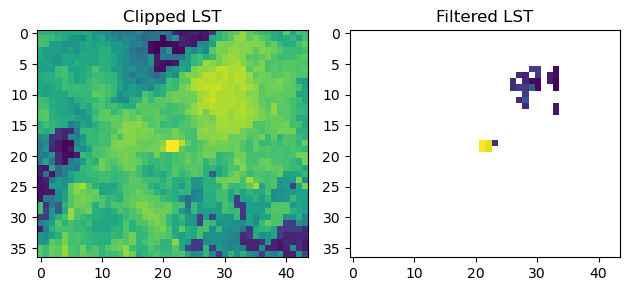

In [11]:

# Create a figure to plot
fig, axs = plt.subplots(1, 2)
axs[0].imshow(lst_clip)
axs[0].set_title('Clipped LST')
# Plot the filtered land surface temperature data on the second subplot
axs[1].imshow(lstf_clip)
axs[1].set_title('Filtered LST') # Add a title for clarity
# Adjust the layout
fig.tight_layout()
# Display the plot
plt.show()

## Create Sentinel-2 L2A True-Color composite


Following the parameters we defined before and the workflow described in the [first part](./511_s2_tfci.ipynb) of this notebook series, we will filter the **Sentinel-2 L2A** data collection to match our event and AOI. This ensures that the visualisations we create are directly relevant to the fire event and set the stage for comparing it with the Land Surface Temperature data from Sentinel-3.


In [12]:
# Interest timeframe parameters for the filtering
date_p = fire_d_s3 + 'T00:00:00Z/' + fire_d_s3 + 'T23:59:59.999999Z' # interest period
def_collection = 'sentinel-2-l2a' # collection

s2_col = list(eopf_catalog.search(
                bbox= search_bbox, # area
                datetime= date_p, #time frame
                collections=def_collection # collection
                ).item_collection())

av_urls = [item.assets["product"].href for item in s2_col]

print(av_urls)

[]


As we can see, there is no capture available for the day on which the fire occurred. This is because **Sentinel-2 L2A** has a **revisit time** of **five** days at the equator, making it possible that, even when the constellation is synchronously retrieving data, the day in question may not be available.<br>
In this case, we define the capture date as the one closest to the event, the **11th June 2025**.

In [13]:
# Interest timeframe parameters for the filtering
date_p = fire_d + 'T00:00:00Z/' + fire_d + 'T23:59:59.999999Z' # interest period
def_collection = 'sentinel-2-l2a' # collection
s2_col = list(eopf_catalog.search(
                bbox= search_bbox, # area
                datetime= date_p, #time frame
                collections=def_collection # collection
                ).item_collection())

av_urls = [item.assets["product"].href for item in s2_col] 
av_urls

['https://objects.eodc.eu:443/e05ab01a9d56408d82ac32d69a5aae2a:202506-s02msil2a/11/products/cpm_v256/S2C_MSIL2A_20250611T101041_N0511_R022_T32TMK_20250611T175918.zarr']

Once we have obtained the available items from the **Sentinel-2 L2A** collection, we can open the asset as a xarray.DataTree.

To prepare the data for further processing, we will extract key metadata like the collection, date, time, and the spectral bands needed for the visualisation (which are conveniently grouped under `r20m` group).

These True-Color composite processing steps include:
- Masking of invalid pixels
- Clipping to AOI
- Band selection
- Normalisation
- Composite creation
- Equalisation


#### Masking out invalid pixels

In [14]:
# We are interested in the datasets contained in the measurements bands for True Colour and False Colour Composites.
s2_zarr = xr.open_datatree(
    av_urls[0], engine="zarr", #we always get the earliest one (the first available item goes last)
    chunks={},
    decode_timedelta=False
    )

# Store interest parameters for further plotting:
date = s2_zarr.attrs['stac_discovery']['properties']['start_datetime'][:10]
time_zarr = s2_zarr.attrs['stac_discovery']['properties']['start_datetime'][11:19]
target_crs = s2_zarr.attrs["stac_discovery"]["properties"]["proj:epsg"]
# Extract the resolution group we are interested to analyse over:
zarr_meas = s2_zarr.measurements.reflectance.r20m

# Extract the cloud free mask at 20m resolution:
l2a_class_20m = s2_zarr.conditions.mask.l2a_classification.r20m.scl
valid_mask = validate_scl(l2a_class_20m)  # Boolean mask (10980x10980)

#### Clipping to AOI

In a next step, we clip the retrieved item to our defined area of interest (AOI).

In [15]:
# True colour channels we are interested to retrieve coposite:
tc_red  = 'b04'
tc_green= 'b03'
tc_blue = 'b02'

# Boolean mask for the 'x' dimension (longitude/easting)
x_mask = (zarr_meas['x'] >= bbox_utm[0]) & (zarr_meas['x'] <= bbox_utm[2])
# Boolean mask for the 'y' dimension (latitude/northing)
y_mask = (zarr_meas['y'] >= bbox_utm[1]) & (zarr_meas['y'] <= bbox_utm[3])

# Combined mask for the bounding box
bbox_mask = x_mask & y_mask

# Extract row and column indices where the mask is True
cols, rows = np.where(bbox_mask)

#### Band selection, normalisation composite creation and equalisation

In the next step, we proceed to select the relevant bands from the item, apply normalisation and equalisation, in order to visualise the True-Color composite of 11 June 2025 over the Nuoto region in Sardinia.

Text(0.5, 1.0, 'Equalised Composite')

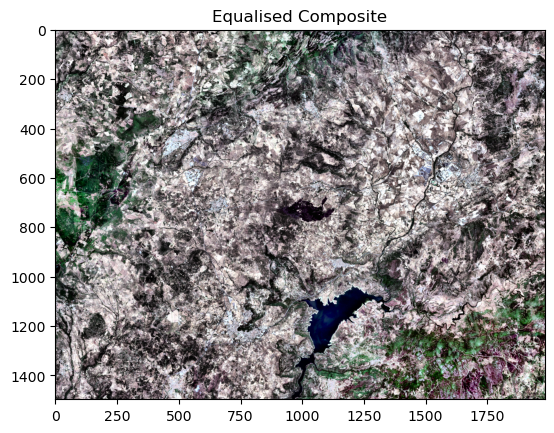

In [16]:
# The tc_red, tc_green, and tc_blue variables are inputs specifying the band names
red = zarr_meas[tc_red].where(valid_mask)
gre =  zarr_meas[tc_green].where(valid_mask)
blu =  zarr_meas[tc_blue].where(valid_mask)

# The mask_sub_utm() function takes the bands and masks them to the valid rows and columns
red = mask_sub_utm(red,rows, cols).values
gre = mask_sub_utm(gre,rows, cols).values
blu = mask_sub_utm(blu,rows, cols).values

# The zarr_meas group is the input dataset containing the dimensions
# by slicing the 'y' dimension array based on the minimum and maximum row indices
y_zarr = zarr_meas['y'].isel(y=slice(rows.min(), rows.max() + 1)).values
# also, the same for the 'x' dimension array based on the minimum and maximum column indices
x_zarr = zarr_meas['x'].isel(x=slice(cols.min(), cols.max() + 1)).values

map_ext_deg = list(t_utm_to_deg.transform(np.nanmin(x_zarr),np.nanmin(y_zarr)) + 
                   t_utm_to_deg.transform(np.nanmax(x_zarr),np.nanmax(y_zarr)))

# Input: percentile range for contrast stretching
contrast_stretch_percentile=(2, 98)
# Input: gamma correction value
gamma=1.8

# Apply normalisation to the red, green and blue bands using the specified percentile and gamma values
red_processed = normalisation_str_gm(red, *contrast_stretch_percentile, gamma)
green_processed = normalisation_str_gm(gre, *contrast_stretch_percentile, gamma)
blue_processed = normalisation_str_gm(blu, *contrast_stretch_percentile, gamma)

# We stack the processed red, green, and blue arrays
rgb_composite_sm = np.dstack((red_processed, green_processed, blue_processed)).astype(np.float32)

#Adding equalisation from skimage:
fire_tc = exposure.equalize_adapthist(rgb_composite_sm)


plt.imshow(fire_tc)
plt.title('Equalised Composite') # Add a title for clarity

## Overlay Sentinel-2 True-Color composite with Sentinel-3 LST data

And finally, we can **georeference** and overlay the two datasets, the True-Color composite from Sentinel-2 as well as the Land Surface Temperature information from Sentinel-3. 


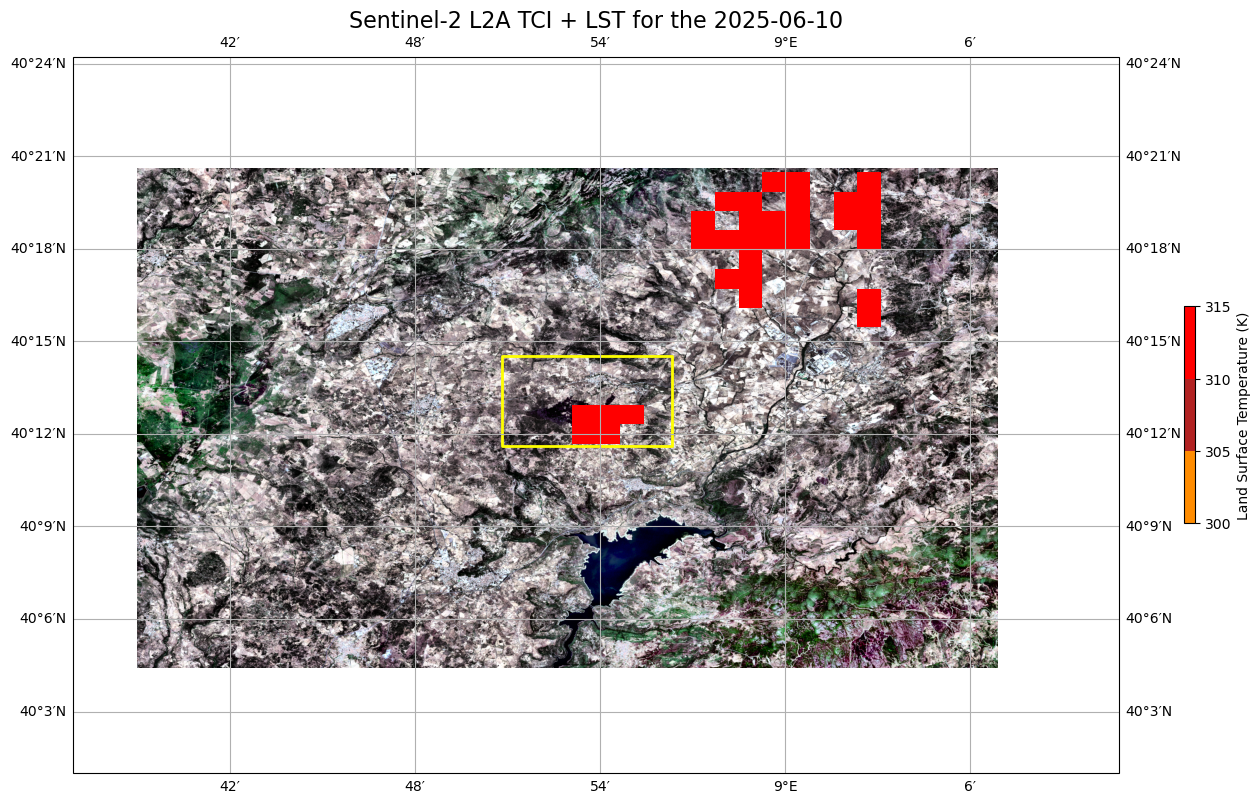

In [17]:
#Overlay
plt.figure(figsize=(14, 8))
# Define the coordinate reference system (CRS) for latitude/longitude
data_ll = ccrs.PlateCarree()

ax = plt.axes(projection=data_ll)
# Display the Sentinel-2 true-colour composite (TCI) image
img = ax.imshow(fire_tc, origin='upper',
                extent=[map_ext_deg[0],map_ext_deg[2],map_ext_deg[1],map_ext_deg[3]],  # item
                transform=data_ll)
# Display the land surface temperature (LST) data as an overlay
im2 = ax.imshow(lstf_clip, origin='upper',
                extent=[np.nanmin(lon_lst), np.nanmax(lon_lst),
                        np.nanmin(lat_lst), np.nanmax(lat_lst)],
                transform=data_ll, # coordinates
                cmap=col_map,  norm=norm) # The custom colour map for LST
cbar = plt.colorbar(im2,ticks=bounds, shrink=0.3)
cbar.set_label("Land Surface Temperature (K)")


# features
ax.add_geometries(map_box, crs=data_ll, facecolor='none', edgecolor='yellow', linewidth=2, linestyle='-')
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False) # Add gridlines and labels

# Adjust title and plot parameters for a tight layout
plt.title(f'Sentinel-2 L2A TCI + LST for the {fire_d_s3}', fontsize=16)
plt.tight_layout()
plt.show()

The **Sentinel-2 L2A** provides the geographical context of the landscape, while the **Sentinel-3 SLSTR** LST information provides an indication of the hottest areas on that day. This allows for a more accurate and immediate understanding of a fire's behaviour during the event. We can see that the hottest detected spot over the area of interest is indeed aligned with the fire event location.<br>

The overlay provides additional information, especially in conditions where optical views are limited. For example, during less light hours or through heavy smoke, the thermal data can still reveal the fire's true footprint.

## Calculating processing time

In [18]:
et = time.time()

total_t = et - st

print('Total Running Time: ', total_t,' seconds')

Total Running Time:  17.805757999420166  seconds


A significant takeaway from this process is its remarkable speed. The entire workflow, from data access to visualisation, is completed in under two minutes. Here is the key evident advantage of using `.zarr` encoding for wildfire detection. <br>
EOPF enables us to quickly access and combine Sentinel data directly from the cloud without the need to download large volumes of data.

<hr>

## 💪 Now it is your turn

### Task

- Go to the Jupyter Hub
- Select the `fire_clean.ipynb` version of this notebook.
- Choose among this two fire events across Europe during this year and replicate the workflow:

#### Ferreira do Alentejo, Portugal
- **Day of the Fire:**<br>
    `2025-06-17`
- **UTM Zone:**<br>
    `29`
- **Bounding box search:**<br>
    `-7.398399,38.545535,-7.278622,38.622615`
- **Suggested Plot:**<br>
    `-7.500248,38.470447,-7.150209,38.674691`
- **Temperature threshold:**<br>
    `325`K

#### Cáceres, Spain
- **Day of the Fire:**<br>
    `2025-06-20`
- **Suggested image:**<br>
    `2025-06-14`
- **UTM Zone:**<br>
    `29`
- **Bounding box search:**<br>
    `-5.784752,39.175948,-5.563653,39.289767`
- **Suggested Plot:**<br>
    `-6.018987,39.030117,-5.351152,39.435294`
- **Temperature threshold:**<br>
    `325`K


#### If you would like to try different visualisation...
Go to [bboxfinder](http://bboxfinder.com/#0.000000,0.000000,0.000000,0.000000) if you would like to modify the plotting extension for a better visualisation!!!

<hr>

## Conclusion

By integrating items from **Sentinel-2** with critical thermal data from **Sentinel-3** through the [EOPF STAC Catalog]() Collections, this notebook has demonstrated a complete and efficient workflow for analysing a real-world wildfire event. <br>

We were able to create **a powerful overlay** that not only shows the **geographical context** of the **burnt area** but also precisely **identifies** the active **heat signatures** associated with the fire. This approach proves that combining different types of satellite data is essential for gaining a complete understanding of complex environmental events.

<table width="100%" style="padding-top: 10px; text-align: center;">
  <tr>
    <td style="font-size: 0.85em; color: #666; vertical-align: middle;">
      &copy; 2025 <a href="https://zarr.eopf.copernicus.eu/" target="_blank"><strong>EOPF Sentinel Zarr Samples</strong></a> &nbsp;|&nbsp;
      &copy; 2025 <a href="https://github.com/eopf-toolkit" target="_blank"><strong>EOPF Toolkit</strong></a>
      <br><br>
      <img src="../static/EOPF-Toolkit-Sample.png" alt="Project Logo" width="400" style="margin-top: 5px;">
    </td>
  </tr>
</table>